In [158]:
import numpy as np
import pandas as pd
import os
from collections import defaultdict

### Globals

In [159]:
OUTPUT_PATH = 'outputs/'
FEATURES_PATH = 'features/'
ALGORITHMS = ['dp1', 'dp2', 'greedy', 'bf', 'bnb', 'cplex']
LEVELS = [1,2,3,6,7,8]
LEVELS_SIZE = [19198 ,9983, 6664,0, 0, 3333, 2857, 2500]
FEATURES = ['num_elem',
            'cap',
            'cap_mean_w',
            'cap_median_w', 
            'cap_desv_w', 
            'mean_w_mean_v',
            'median_w_median_v', 
            'desv_w_desv_v',
            'max_w_min_w',
            'max_v_min_v',
            'mean_w',
            'median_w', 
            'desv_w', 
            'min_w', 
            'max_w', 
            'mean_v', 
            'median_v', 
            'desv_v', 
            'min_v', 
            'max_v',
            'p_coef' 
           ]

### Helpers

In [160]:
def get_features(lvl, id_):
    return np.array(open(FEATURES_PATH +str(lvl)+'/'+ str(id_),'r').read().split(), dtype=float)

def get_best(lvl, id_, t):
    best_fo = 0
    best_alg = 0
    best_time = 900000
    for alg in ALGORITHMS:
        if lvl not in alg_data[alg].keys(): continue
        if id_ not in alg_data[alg][lvl].keys(): continue
        for res in alg_data[alg][lvl][id_]:
            if res[1] < t:
                if res[0] > best_fo:
                    best_fo = res[0]
                    best_time = res[1]
                    best_alg = ALGORITHMS.index(alg)
                
                elif res[0] == best_fo and res[1] < best_time:
                    best_time = res[1]
                    best_alg = ALGORITHMS.index(alg)
    return best_alg+1

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(7), predictions_array, color="#777777")
    plt.ylim([0, 1]) 
    plt.xticks(np.arange(7), ALGORITHMS)
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

### Reading outputs

In [161]:
output_files = os.listdir(OUTPUT_PATH)
alg_data = defaultdict(list)

print("Faltan los siguientes resultados:")
for alg in ALGORITHMS:
    alg_data[alg] = defaultdict(list)
    for lvl in LEVELS:
        filename = alg + "_" + str(lvl)
        if filename not in output_files: # En caso de que todavía no hayan resultados
            print(alg, lvl)
            continue
        alg_data[alg][lvl] = defaultdict(list)
        file = open(OUTPUT_PATH+filename,'r')
        for row in file:
            id_, fo, time = row.split()
            alg_data[alg][lvl][int(id_)].append([(float)(fo), (float)(time)])

Faltan los siguientes resultados:
dp1 6
dp1 7
dp2 3
dp2 6
dp2 7
dp2 8
greedy 8
bnb 8
cplex 6
cplex 7
cplex 8


In [105]:
# comparing al ojo
lvl_ = 6
id_ = 33
print("Features: ", get_features(lvl_, id_))
for alg in ALGORITHMS:
    if lvl_ in alg_data[alg]:
        if id_ in alg_data[alg][lvl_]:
            print(alg, alg_data[alg][lvl_][id_])
    
print('BEST: ',ALGORITHMS[get_best(lvl_,id_,1)])

Features:  [ 1.05132000e+05  6.20190000e+04  2.00002931e+00  1.99797043e+00
  3.45401114e+00  4.78519113e-01  4.79146085e-01  4.80291897e-01
  6.20150000e+04  1.29598000e+05  3.10090456e+04  3.10410000e+04
  1.79556456e+04  2.00000000e+00  6.20170000e+04  6.48021046e+04
  6.47840000e+04  3.73848606e+04  1.00000000e+00  1.29599000e+05
 -3.24874867e-03]
greedy [[34786905.0, 0.019811]]
bf [[-1.0, -1.0]]
bnb [[1149655.0, 0.060707], [2109483.0, 0.065099], [3211855.0, 0.069291], [4155209.0, 0.073327], [5204743.0, 0.077353], [6266873.0, 0.081355], [7292631.0, 0.085223], [8004248.0, 0.089095], [8895013.0, 0.092969], [9699179.0, 0.096684], [10687140.0, 0.100405], [11623073.0, 0.104123], [12606337.0, 0.107726], [13531786.0, 0.111307], [14493556.0, 0.114888], [15425104.0, 0.118407], [16337223.0, 0.121858], [17212703.0, 0.125299], [18117885.0, 0.128768], [19117529.0, 0.132109], [19948997.0, 0.135444], [20727484.0, 0.138793], [21592562.0, 0.142105], [22642608.0, 0.145339], [23670397.0, 0.148559], [

In [162]:
timesteps = np.logspace(1, 30, num=100, base=1.1)-1.1 # escala logaritmica para los tiempos

In [133]:
for alg in ALGORITHMS:
    print(alg, len(alg_data[alg][8]))

dp1 1368
dp2 0
greedy 0
bf 2500
bnb 0
cplex 0


In [163]:
train_data = []
train_label = []

count = 0

for lvl in LEVELS:
    print("level "+str(lvl)+"...")
    for id_ in range(LEVELS_SIZE[lvl-1]):
        fts = get_features(lvl, id_)
        for t in timesteps:
            train_data.append([*fts, t+1])
            train_label.append(get_best(lvl, id_, t))
        count += 1

level 1...
level 2...
level 3...
level 6...
level 7...
level 8...


In [ ]:
data = pd.DataFrame(data=train_data, columns=[*FEATURES, 't'])

## NN

In [142]:
# TensorFlow and tf.keras# Tensor 
import tensorflow as tf
#from tensorflow import keras
#from keras.layers import Dropout, Dense
from keras import Sequential
from keras import optimizers
from keras.models import Model   
from keras.layers import *
import keras
# Helper libraries
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split

/home/miguel/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Train and Test set

In [164]:
X_train, X_test, y_train, y_test = train_test_split(train_data, train_label, test_size=0.3, random_state=42)

### Saving

In [ ]:
with open('X_train.csv', 'w') as FOUT:
    np.savetxt(FOUT, X_train)
with open('X_test.csv', 'w') as FOUT:
    np.savetxt(FOUT, X_test)
with open('y_train.csv', 'w') as FOUT:
    np.savetxt(FOUT, y_train)
with open('y_test.csv', 'w') as FOUT:
    np.savetxt(FOUT, y_test)

### Loading

##### Train set

In [ ]:
y_train = np.loadtxt('y_train.csv', dtype=float)
X_train = np.loadtxt('X_train.csv', dtype=float)

###### Test set

In [ ]:
X_test = np.loadtxt('X_test.csv', dtype=float)
y_test = np.loadtxt('y_test.csv', dtype=float)

### Model

In [147]:
model = Sequential([
    Dense(128, input_shape = (22,), activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.5), 
    Dense(64, activation='relu'),
    Dropout(0.5), 
    Dense(7, activation='softmax')
])

In [148]:
# sgd = optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [149]:
history = model.fit(np.array(X_train), 
                    np.array(y_train), 
                    epochs=2,
                    validation_split=0.3)

Train on 2182215 samples, validate on 935235 samples
Epoch 1/2
1506464/2182215 [===================>..........] - ETA: 18s - loss: 1.1572 - acc: 0.3606

KeyboardInterrupt: 

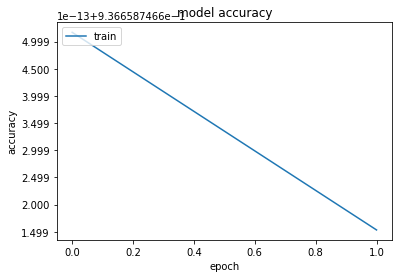

In [16]:
plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

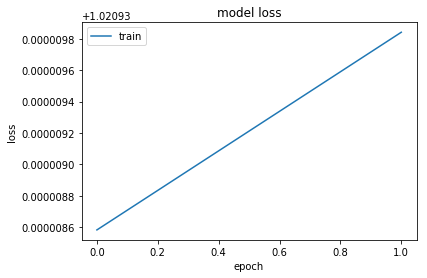

In [17]:
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [150]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0, n_jobs=-1 ,verbose=1)
h = clf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.0min finished


In [151]:
clf.score(X_test, y_test)

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    6.2s finished


0.6365592605067175

In [152]:
pred = clf.predict(X_test)

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    5.5s finished


In [ ]:
from sklearn import svm

clfsvm = svm.LinearSVC()
clfsvm.fit(X_train, y_train)  

In [ ]:
clfsvm.score(X_test, y_test)

### Evaluate Accuracy (test set)

In [19]:
test_loss, test_acc = model.evaluate(np.array(X_test), np.array(y_test))

print('Test accuracy:', test_acc)

1605840/1605840 [==============================] - 15s 10us/step
Test accuracy: 0.9367695411747123


### Individual Predictions

In [21]:
pred = model.predict(np.array(X_test))

In [ ]:
# rojo predicho
# azul verdadero
i = 5
print(X_test[i])
print(pred[:10])
print(y_test[:10])
plt.figure()
plot_value_array(i, pred,  np.array(y_test, dtype=int))

### Confusion matrix

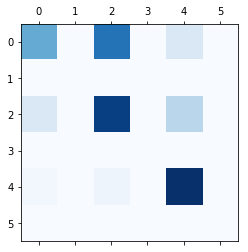

In [153]:
#best_predictions = np.argmax(pred,axis=1)

cm = sklearn.metrics.confusion_matrix(np.array(y_test, dtype=int), pred)

fig, ax = plt.subplots()

ax.matshow(cm, cmap=plt.cm.Blues)

In [26]:
set(y_test)

{0, 1, 3, 4}

In [ ]:
sample = np.array(X_test[0])
sample = (np.expand_dims(sample,0))
predictions_single = model.predict(sample)

print(predictions_single)

In [ ]:
y_test[0]